In [1]:
import glob

train_filenames = glob.glob('./train/*.txt')
val_filenames = glob.glob('./val/*.txt')
print(val_filenames)

['./val\\af.txt', './val\\cn.txt', './val\\de.txt', './val\\fi.txt', './val\\fr.txt', './val\\in.txt', './val\\ir.txt', './val\\pk.txt', './val\\za.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
import codecs

# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
train_categories = []

category_lines_val = {}
val_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in train_filenames:
    category = filename.split('\\')[-1].split('.')[0]
    train_categories.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines

for filename in val_filenames:
    category = filename.split('\\')[-1].split('.')[0]
    val_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines    

n_categories = len(val_categories)
print('n_categories =', n_categories)

n_categories = 9


In [4]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [5]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))


In [6]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 9])


In [8]:
input = Variable(line_to_tensor('hindu'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:
-2.1220 -2.2679 -2.2247 -2.2711 -2.2131 -2.1564 -2.2315 -2.1837 -2.1178
[torch.FloatTensor of size 1x9]



In [9]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return train_categories[category_i], category_i

print(category_from_output(output))

('za', 8)


In [10]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(train_categories)
    line = random.choice(category_lines_train[category])
    category_tensor = Variable(torch.LongTensor([train_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = za / line = arzamasovka
category = za / line = islauzai
category = af / line = sad khak
category = cn / line = xichentun
category = de / line = hagenohsen
category = za / line = niekerkshoop
category = af / line = dakhanisabzvari
category = de / line = saintjuliendechedon
category = fi / line = tiis
category = in / line = tingchien


In [11]:
import random

def random_validation_pair():                                                                                                               
    category = random.choice(val_categories)
    line = random.choice(category_lines_val[category])
    category_tensor = Variable(torch.LongTensor([val_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_validation_pair()
    print('category =', category, '/ line =', line)

category = in / line = aydinlikevler
category = de / line = ardeu
category = cn / line = xixin
category = de / line = rizadey
category = za / line = az zawai
category = af / line = ghulam mustafaabad
category = af / line = souk tafetecht
category = cn / line = baomin
category = pk / line = chandar gol
category = fi / line = puotinharju


In [12]:
criterion = nn.NLLLoss()


In [13]:
learning_rate = 2e-4 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [14]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]

In [15]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000
accuracy = 0
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        if guess == category:
            accuracy += 1
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 32s) 1.8933 khak chopan / za ✗ (af)
10000 10% (1m 3s) 1.9770 krasnyy sibiryak / fi ✗ (ir)
15000 15% (1m 34s) 1.4322 seitzweiler / de ✓
20000 20% (2m 6s) 1.2252 khairi / pk ✓
25000 25% (2m 37s) 1.7350 breivikeidet / fr ✗ (de)
30000 30% (3m 8s) 1.2887 ranta / fi ✓
35000 35% (3m 38s) 0.6512 la figuera / fi ✓
40000 40% (4m 9s) 0.4255 radoestidejos / de ✓
45000 45% (4m 40s) 0.2975 verkhnyaya gezaldara / za ✓
50000 50% (5m 10s) 1.0142 qaskoh / af ✓
55000 55% (5m 41s) 0.9787 ksiri / ir ✓
60000 60% (6m 12s) 1.5287 linbu / fi ✗ (in)
65000 65% (6m 40s) 1.4023 kshirapara / fi ✗ (ir)
70000 70% (7m 11s) 0.9635 baghak / pk ✓
75000 75% (7m 42s) 3.1942 karzalanga / za ✗ (ir)
80000 80% (8m 5s) 1.8065 fukwong / af ✗ (cn)
85000 85% (8m 29s) 0.8968 dzabto khan / af ✓
90000 90% (8m 55s) 0.2770 shigoulingxia / cn ✓
95000 95% (9m 23s) 0.9905 pulakorpi / fi ✓
100000 100% (9m 52s) 0.6505 cotino / in ✓


In [16]:
accuracy /= n_epochs
print(accuracy)

0.00013


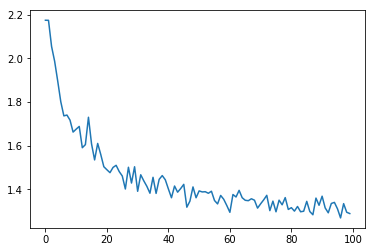

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

0.5063


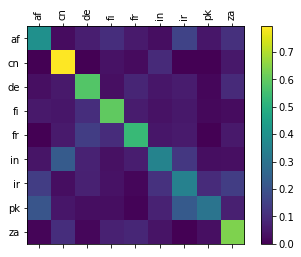

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed

total_count = 0
correct_count = 0
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_validation_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = val_categories.index(category)
    if category_i == guess_i:
        correct_count += 1
    confusion[category_i][guess_i] += 1
    total_count += 1

accuracy = correct_count / total_count
print(accuracy)
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + train_categories, rotation=90)
ax.set_yticklabels([''] + val_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, train_categories[category_index]))
        predictions.append([value, train_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-1.12) fi
(-1.63) fr
(-2.09) de

> Jackson
(-1.69) za
(-1.90) cn
(-1.99) ir

> Satoshi
(-1.17) cn
(-1.76) pk
(-1.97) ir


In [21]:
lines = readLines('./cities_test.txt')
out_lines = []
for line in lines:
    line_tensor = Variable(line_to_tensor(line))
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    out_lines.append(guess)
    
with open('labels.txt', 'w') as f:
    for line in out_lines:
        f.write(line + '\n')